In [7]:
# Setup
import sys
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
from Models import Baseline
import importlib

utils = pkmnUtils.PokemonUtils(rel_loc="")
utils.loadAllGIFs()
x_train, x_val, x_test, y_train, y_val, y_test = utils.generateXYSplitsV1()

USE_GPU = True
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

def trainBatches(batch_size):
    for batch in range(int(len(x_train) / batch_size)):
        yield x_train[batch * batch_size: (batch + 1) * batch_size], y_train[batch * batch_size: (batch + 1) * batch_size]

def valBatches(batch_size):
    for batch in range(int(len(x_val) / batch_size)):
        yield x_val[batch * batch_size: (batch + 1) * batch_size], y_val[batch * batch_size: (batch + 1) * batch_size]

def testBatches(batch_size):
    for batch in range(int(len(x_test) / batch_size)):
        yield x_test[batch * batch_size: (batch + 1) * batch_size], y_test[batch * batch_size: (batch + 1) * batch_size]

25 done!
50 done!
75 done!
100 done!
125 done!
150 done!
175 done!
200 done!
225 done!
250 done!
275 done!
300 done!
325 done!
350 done!
375 done!
400 done!
425 done!
450 done!
475 done!
500 done!
525 done!
550 done!
575 done!
600 done!
625 done!
650 done!
675 done!
700 done!
725 done!
750 done!
775 done!
800 done!
825 done!
850 done!
875 done!
900 done!
925 done!
all 940 done!
smallest: [14 15 29  4]
largest: [299 188 234   4]
x_train: (601, 128, 128, 4)
x_val:   (151, 128, 128, 4)
x_test:  (188, 128, 128, 4)
y_train: (601,)
y_val:   (151,)
y_test:  (188,)


In [ ]:
# Run on PokemonUtils update
import Utils.PokemonUtils as pkmnUtils
importlib.reload(pkmnUtils)  # update import if PokemonUtils.py changes
utils = pkmnUtils.PokemonUtils(utils=utils)

In [38]:
# Run on model update
from Models import Baseline
importlib.reload(Baseline)

<module 'Models.Baseline' from '/home/benjaminshare/pokemon-learning/Models/Baseline.py'>

In [24]:
def check_accuracy(sess, dset, x, scores, verbose=True):
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [91]:
# Train model
model = Baseline.ShallowNet()
num_epochs = 2
learning_rate = 1e-3
batch_size = 16
print_every = 10
reg_weight = 0.01
DEBUG = False

tf.reset_default_graph()    
with tf.device(device):
    x = tf.placeholder(tf.float32, [None, 128, 128, 4])
    y = tf.placeholder(tf.int32, [None])

    is_training = tf.placeholder(tf.bool, name='is_training')

    partials, scores = model.model_init_fn(x, DEBUG, reg_weight)

    error_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.reduce_mean(error_loss + sum(reg_losses))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        acc_checks = []
        train_accs = []
        val_accs = []
        err_vals = []
        reg_vals = []
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_batch, y_batch in trainBatches(batch_size):
                feed_dict = {x: x_batch, y: y_batch, is_training:1}
                if DEBUG:
                    loss_np, _, p0, p1, p2, p3 = sess.run([loss, train_op, partials[0], partials[1], partials[2], partials[3]], feed_dict=feed_dict)
                    print("p0:", p0.shape)
                    print("p1:", p1.shape)
                    print("p2:", p2.shape)
                    print("p3:", p3.shape)
                else:
                    loss_np, el, rl, _ = sess.run([loss, error_loss, reg_losses, train_op], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    acc_checks.append(t)
                    train_accs.append(check_accuracy(sess, trainBatches(batch_size), x, scores, verbose=False))
                    val_accs.append(check_accuracy(sess, valBatches(batch_size), x, scores))
                    err_vals.append(tf.reduce_mean(el).eval())
                    reg_vals.append(sum(rl))
                    print()
                t += 1
                    

Starting epoch 0
Iteration 0, loss = 47.4425
Got 11 / 144 correct (7.64%)

Iteration 10, loss = 5.3585
Got 17 / 144 correct (11.81%)

Iteration 20, loss = 4.8255
Got 18 / 144 correct (12.50%)

Iteration 30, loss = 4.9528
Got 17 / 144 correct (11.81%)

Starting epoch 1
Iteration 40, loss = 4.6947
Got 16 / 144 correct (11.11%)

Iteration 50, loss = 4.4909
Got 17 / 144 correct (11.81%)

Iteration 60, loss = 4.5060
Got 18 / 144 correct (12.50%)

Iteration 70, loss = 4.4900
Got 16 / 144 correct (11.11%)



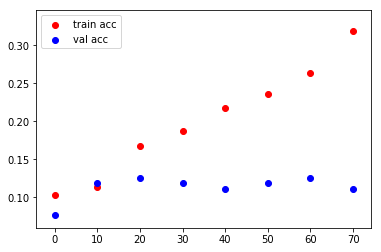

In [92]:
# Print training losses on train/val sets
plt.figure()
plt.scatter(acc_checks, train_accs, c='red')
plt.scatter(acc_checks, val_accs, c='blue')
plt.legend(["train acc", "val acc"])
plt.savefig("Results/training_loss_%.2freg.jpg" %reg_weight)

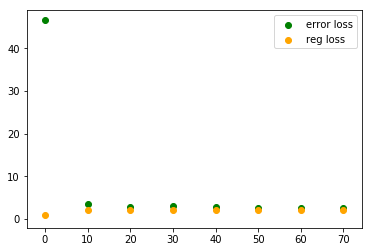

In [93]:
plt.figure()
plt.scatter(acc_checks, err_vals, c='green')
plt.scatter(acc_checks, reg_vals, c='orange')
plt.legend(["error loss", "reg loss"])
plt.savefig("Results/relative_losses_%.2freg.jpg" %reg_weight)

In [ ]:
# Test model
acc = None
pass
print(acc)